In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import seaborn as sns
import numpy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

/home/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df_city_time_series = pd.read_csv("City_time_series.csv",parse_dates=['Date'])

In [4]:
df_city_time_series = df_city_time_series.dropna(subset=['ZHVIPerSqft_AllHomes'])

In [10]:
df_city_time_series.head()

,Date,RegionName,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,MedianListingPricePerSqft_AllHomes,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
1,1996-04-30,aberdeenbinghamid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,168400.0,NaN,NaN,NaN,NaN,NaN
2,1996-04-30,aberdeenharfordmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81300.0,137900.0,109600.0,108600.0,147900.0,NaN,NaN,NaN,NaN,NaN
5,1996-04-30,abernathyhaletx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1996-04-30,abingdonharfordmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91000.0,87600.0,123900.0,125600.0,169700.0,NaN,NaN,NaN,NaN,NaN
9,1996-04-30,abingdonwashingtonva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,89400.0,89400.0,155000.0,NaN,NaN,NaN,NaN,NaN


In [8]:
df_zhvi_sqft_all = df_city_time_series.set_index('Date').groupby(pd.Grouper(freq='d')).mean().dropna(how='all').ZHVIPerSqft_AllHomes

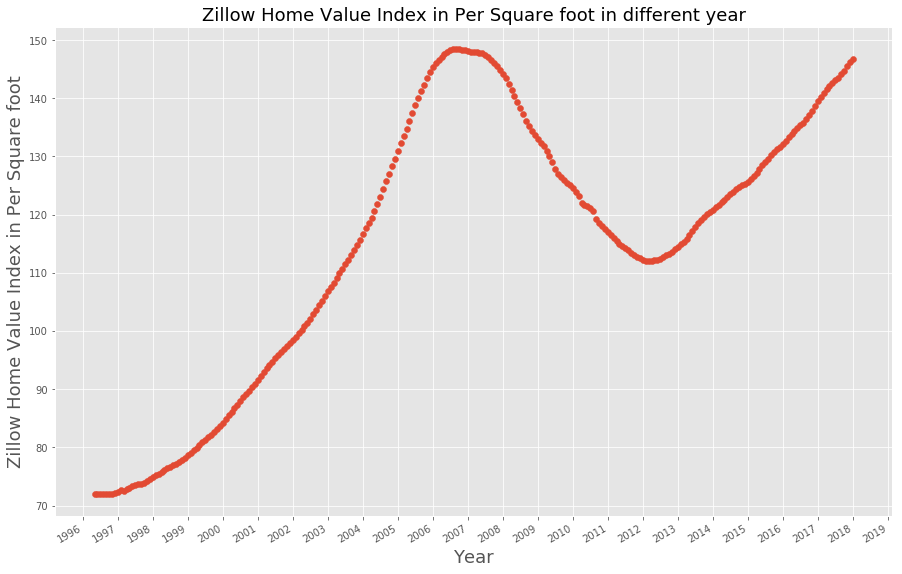

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_zhvi_sqft_all.index, df_zhvi_sqft_all)
# change x axis year location interval to 1 year. So that it displays data in interval of 1 year
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# Add the title to the graph
plt.title('Zillow Home Value Index in Per Square foot in different year', fontsize=18)
# add xlabel
plt.xlabel('Year', fontsize=18)
# add ylabel
plt.ylabel('Zillow Home Value Index in Per Square foot', fontsize=18)
# beautify the x axis date presentation
fig.autofmt_xdate()
# And finally show the plot in a new window.
plt.show()

In [12]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [13]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [14]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [15]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [16]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [17]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [18]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size, verbose=0)
	return yhat[0,0]

In [19]:


# convert our column to pandas series 
series = pd.Series(df_zhvi_sqft_all)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)



In [20]:


# repeat 30 times
repeats = 30
# variable for keep track of error scores
error_scores = list()
for r in range(repeats):
    # let's train
    lstm_model = fit_lstm(train_scaled, 1, 30, 4)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)



1) Test RMSE: 0.455
2) Test RMSE: 0.486
3) Test RMSE: 0.493
4) Test RMSE: 0.477
5) Test RMSE: 0.496
6) Test RMSE: 0.481
7) Test RMSE: 0.482
8) Test RMSE: 0.501
9) Test RMSE: 0.497
10) Test RMSE: 0.498
11) Test RMSE: 0.487
12) Test RMSE: 0.476
13) Test RMSE: 0.487
14) Test RMSE: 0.488
15) Test RMSE: 0.469
16) Test RMSE: 0.476
17) Test RMSE: 0.487
18) Test RMSE: 0.467
19) Test RMSE: 0.487
20) Test RMSE: 0.486
21) Test RMSE: 0.471
22) Test RMSE: 0.453
23) Test RMSE: 0.491
24) Test RMSE: 0.485
25) Test RMSE: 0.486
26) Test RMSE: 0.480
27) Test RMSE: 0.492
28) Test RMSE: 0.440
29) Test RMSE: 0.482
30) Test RMSE: 0.482


In [21]:
# report performance
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
# print(results.describe())
# results.boxplot()
# plt.show()

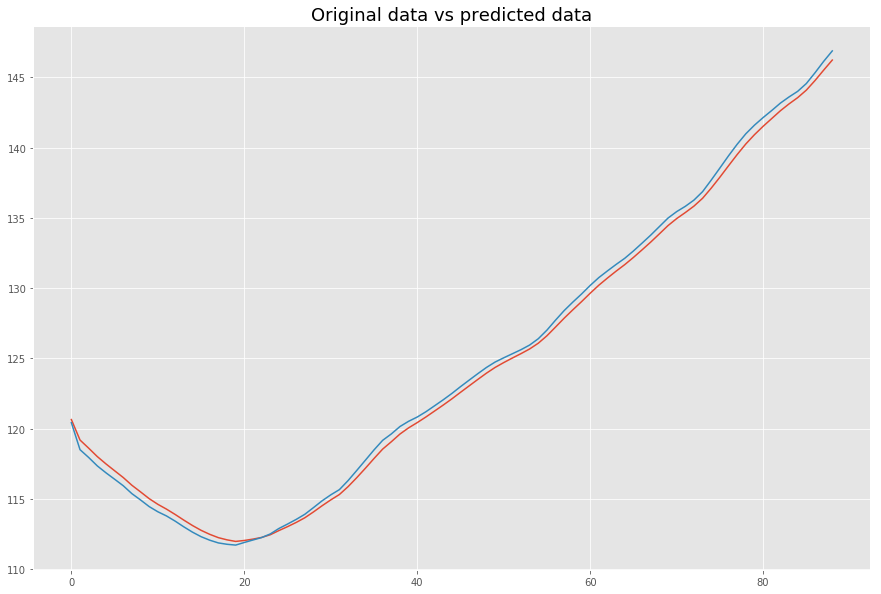

In [22]:
# line plot of observed vs predicted
plt.figure(figsize=(15, 10))
plt.plot(raw_values[train_size:len(supervised_values)])
plt.plot(predictions)
plt.title('Original data vs predicted data', fontsize=18)
plt.show()

In [23]:
# last value of our dataset
f = np.array(151.072060)
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(f)
# let's transform
train = f.reshape(1, 1)
train_scaled = scaler.transform(train)

In [24]:
# initial record
initial = train_scaled
# store prediction
prediction = []
# range 40 because we want the prediction for next 40 months
for i in range(40):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = np.array([yhat])

In [26]:


prediction = np.concatenate(prediction, axis=0 ).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)



In [27]:
rng = pd.date_range('2017-08-31 00:00:00', periods=40, freq='M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['Date', 'ZHVIPerSqft_AllHomes']
prediction

,Date,ZHVIPerSqft_AllHomes
0,2017-08-31,151.455078
1,2017-09-30,151.441055
2,2017-10-31,151.422791
3,2017-11-30,151.406296
4,2017-12-31,151.390930
5,2018-01-31,151.376480
6,2018-02-28,151.362900
7,2018-03-31,151.350189
8,2018-04-30,151.338364
9,2018-05-31,151.327423


In [28]:
plt.rc('figure', figsize=(15, 10))

In [29]:
original = pd.DataFrame({'Date':df_zhvi_sqft_all.index, 'ZHVIPerSqft_AllHomes':df_zhvi_sqft_all.values})
original

,Date,ZHVIPerSqft_AllHomes
0,1996-04-30,72.056369
1,1996-05-31,72.021660
2,1996-06-30,71.979891
3,1996-07-31,71.976152
4,1996-08-31,71.964629
5,1996-09-30,71.986963
6,1996-10-31,72.038683
7,1996-11-30,72.175013
8,1996-12-31,72.350347
9,1997-01-31,72.589137


In [30]:
frames = [original, prediction]
df_final = pd.concat(frames)
df_final.set_index(['Date'],inplace=True)

In [32]:
df_final = pd.Series(df_final.ZHVIPerSqft_AllHomes)

In [33]:
plt.rc('figure', figsize=(15, 10))

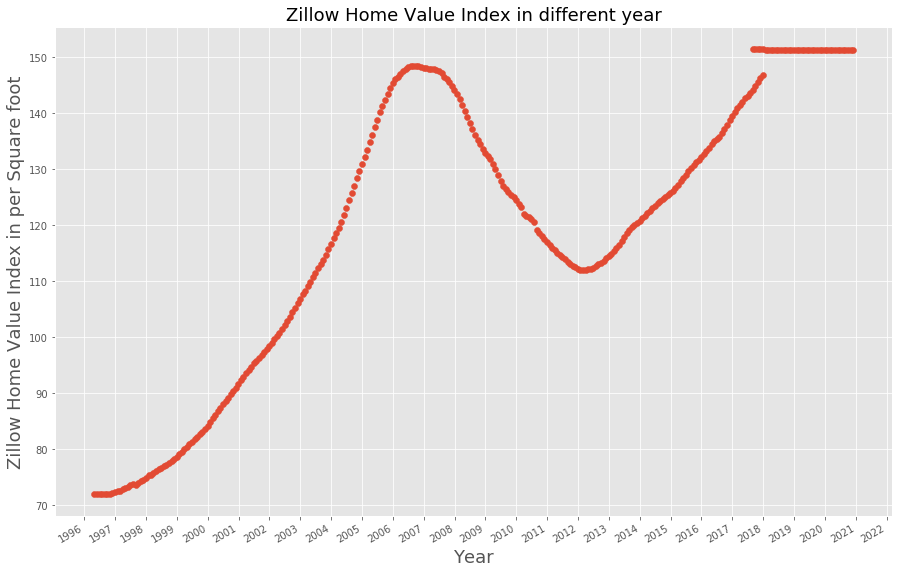

In [34]:
# df_final.plot(figsize=(15, 5),x_compat=True)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_final.index, df_final)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Zillow Home Value Index in different year', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Zillow Home Value Index in per Square foot', fontsize=18)
fig.autofmt_xdate()
plt.show()